In [1]:
import numpy as np
import cv2
from math import atan2, degrees, sin, cos
import random
import itertools
import copy
import sys

from sklearn.cluster import KMeans
from scipy.special import comb

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


### open an Image

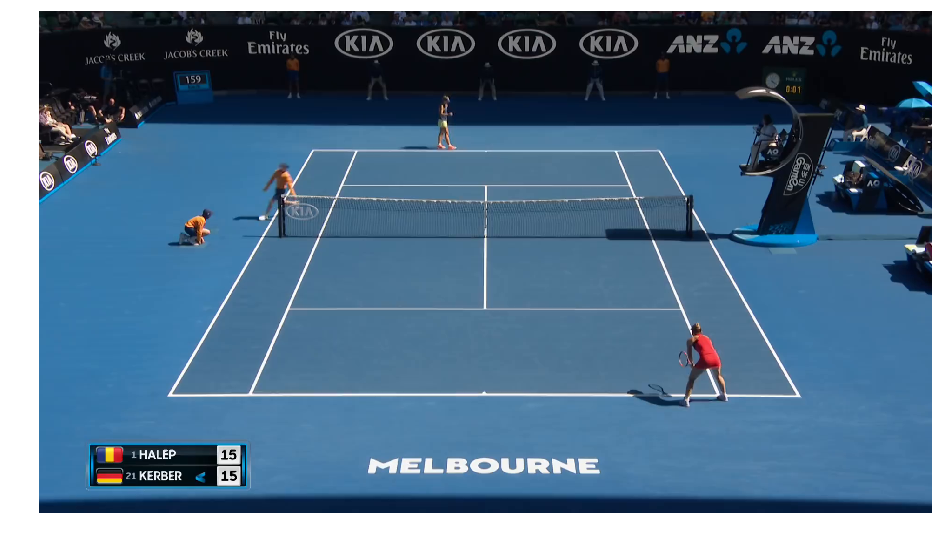

In [16]:
frame = cv2.imread('../images/3_image_GP_00306.png')

def imshow(img, save=None):
    frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure( figsize=(16,10))
    plt.imshow(frame)
    plt.axis('off')
    if save is not None:
        plt.savefig(save, bbox_inches='tight', pad_inches=0)

def ptransform(points, h):
    points_new = []
    for p in [[pt[0], pt[1],1] for pt in points]:
        hp = np.dot(h,p)
        if hp[2] < 1e-12:
            return None
        else:
            points_new.append((int(hp[0]/hp[2]), int(hp[1]/hp[2])))

    return points_new


imshow(frame)

### find lines in the thresholded image by using Canny edge detector and HoughLines 

In [10]:
edges = cv2.Canny(gray_thrs, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges,1,np.pi/180,200)

NameError: name 'gray_thrs' is not defined

In [11]:
#delta_rho
drho = 10
#delta_theta
dtheta = .01

### define the tennis court

In [12]:
    x0 = 25
    y0 = 25

    thicknes = 10

    total_len = 936
    total_width = 432

    far_left = (x0,y0)
    far_left_single = (x0+54,y0) # 4 foot 6 inches
    far_right_single = (x0+378,y0)
    far_right = (x0+total_width,y0) # 36 feet

    near_left = (x0, y0+total_len)
    near_left_single = (x0+54,y0+total_len) # 4 foot 6 inches
    near_right_single = (x0+378,y0+total_len)
    near_right = (x0+total_width,y0+total_len) # 36 feet

    far_left_service = (x0+54, y0+216)
    far_left_outer_service = (x0, y0+216)
    far_right_service = (x0+378, y0+216)
    far_center_service = (x0+216, y0+216)
    far_right_outer_service = (x0+total_width, y0+216)

    near_left_service = (x0+54, y0+720)
    near_left_outer_service =  (x0, y0+720 )
    near_right_service = (x0+378, y0+720)
    near_center_service = (x0+216, y0+720)
    near_right_outer_service = (x0+total_width, y0+720)
    near_center = (x0+216, y0+total_len)


    center_left = (x0-36,936//2)
    center_right = (x0+total_width+36, 936//2)

    left_net_post = (x0-36,936//2,42)
    right_net_post = (total_width+36,936//2,42)

    court_points = np.array([[x[0],x[1],1] for x in [far_left,far_left_single,far_right_single,far_right,
    near_left,near_left_single,near_right_single,near_right,
    far_left_service,far_right_service,far_center_service,
    near_left_service,near_right_service,near_center_service, center_left, center_right]])


### Find the lower half court lines

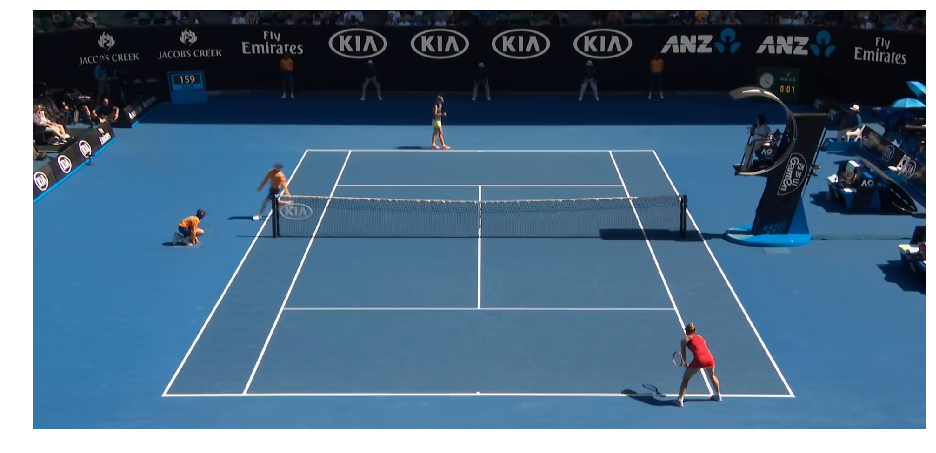

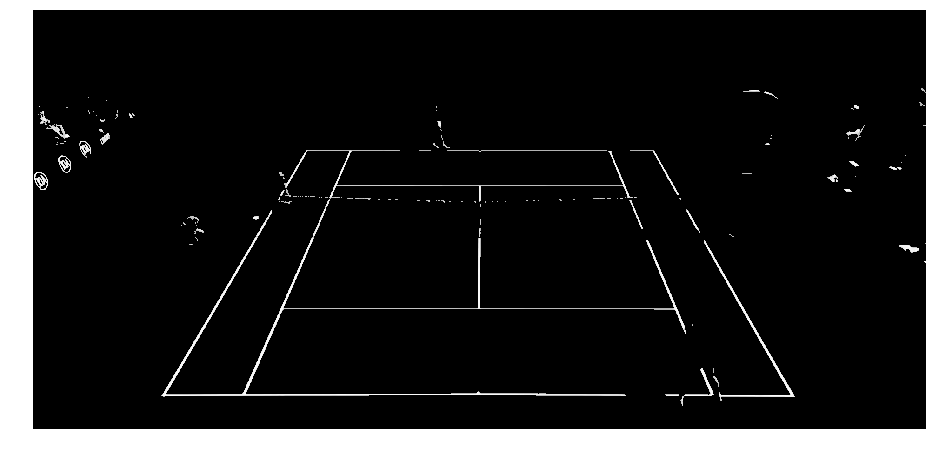

[6130, 0, 0, 0, 0, 0, 0, 0, 0, 0]
found in  16  loops  6130  white pixels


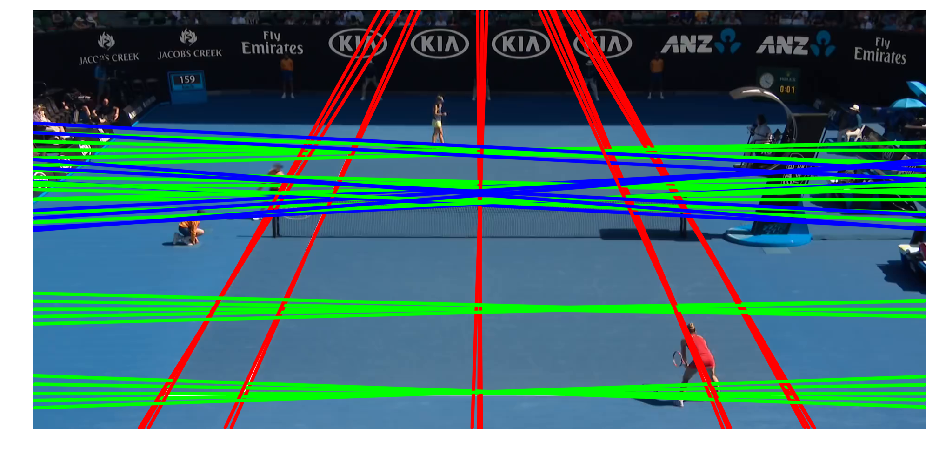

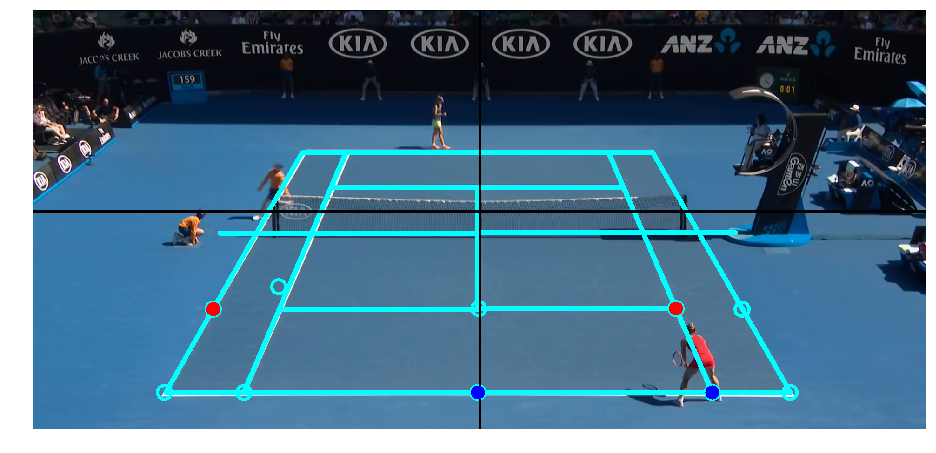

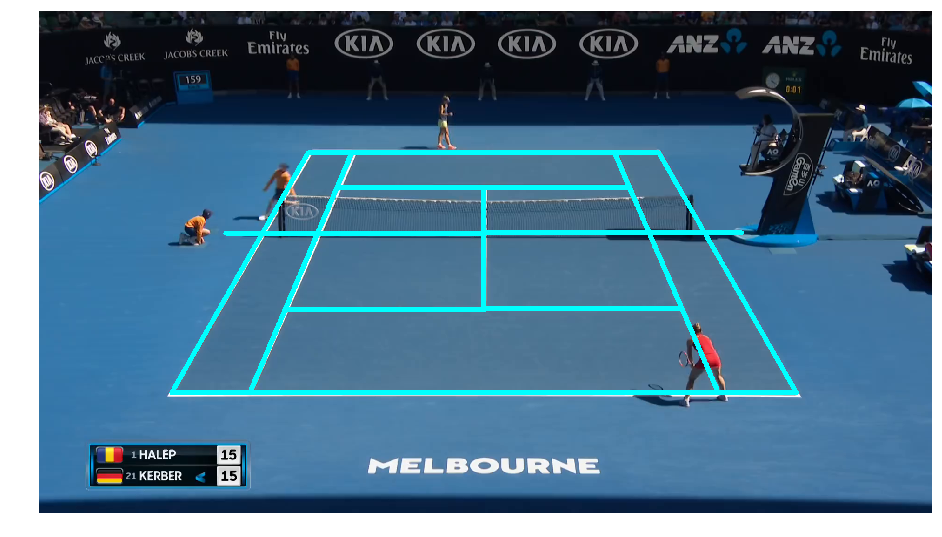

In [17]:
white_pixels_last_frame = [0]*10
h_last_frame = None
warp_lines = None
count = -1
est = True
no_out = True
count += 1
best_combo = None
white_pixels_old = -1
h_best = None

frame = cv2.imread('../images/3_image_GP_00306.png')
frame_heigt, frame_width, _ = frame.shape
frame_=copy.deepcopy(frame)
frame = frame[:900, :, :]
# frame = cv2.resize(frame, (980,560))
imshow(frame)
thres = np.max(frame)*.7
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
th, dst = cv2.threshold(gray, thres, 255, cv2.THRESH_BINARY)
gray_threshold = cv2.bitwise_and(gray, gray, mask = dst)

plt.figure(figsize=(16,10))
plt.imshow(gray_threshold, cmap='gist_gray')
plt.axis('off')
plt.savefig('threshold.png', bbox_inches='tight', pad_inches=0)
plt.show()

edges = cv2.Canny(gray_threshold, 50, 200)
lines = cv2.HoughLines(edges, 1, np.pi/360.0, 75, np.array([]), 0, 0)
groups = [[],[],[]]

#delta_rho
drho = 15
#delta_thetagroups
dtheta = .02

num_ints = 0
num_clusters = 10

cp_ = copy.deepcopy(frame)

if not lines is None:
    for ph in lines:
        rho,theta = ph[0]
        a_ = np.cos(theta)
        b_ = np.sin(theta)
        x0 = a_*rho
        y0 = b_*rho
        x1 = int(x0 + 2000*(-b_))
        y1 = int(y0 + 2000*(a_))
        x2 = int(x0 - 2000*(-b_))
        y2 = int(y0 - 2000*(a_))

        if abs(theta) > 2 or abs(theta) < 1.05:
            if any(abs(t[0]-rho)<drho and abs(t[1]-theta) < dtheta for t in groups[0]):
                pass
            else:
                groups[0].append(ph[0])
                cv2.line(cp_,(x1,y1),(x2,y2),(0,0,255),5, cv2.LINE_AA)
        elif abs(theta)>1.52 and abs(theta)<1.62:
            if any(abs(t[0]-rho)<drho and abs(t[1]-theta) < dtheta for t in groups[1]):
                pass
            else:
                groups[1].append(ph[0])
                cv2.line(cp_,(x1,y1),(x2,y2),(0,255,0),5, cv2.LINE_AA)
        else:
            if any(abs(t[0]-rho)<drho and abs(t[1]-theta) < dtheta for t in groups[2]):
                pass
            else:
                groups[2].append(ph[0])
                cv2.line(cp_,(x1,y1),(x2,y2),(255,0,0),5, cv2.LINE_AA)
    
    imshow(cp_, save='lines.png')
    if (len(groups[0]) < 2 ) or (len(groups[1]) < 2):
        # cv2.imshow('frame', frame)
        h_best = h_last_frame

    heigh_const = frame_heigt*0.4
    ints = []
    for a in groups[0]:
        for b in groups[1]:
            num_ints +=1
            c = np.linalg.solve([[cos(a[1]), sin(a[1])],[cos(b[1]), sin(b[1])]], [a[0], b[0]])
            if c[1] > heigh_const and c[1] < frame.shape[0]:
                ints.append(c)
            # cv2.circle(frame, tuple([int(x) for x in c]), 15, (255,255,0), 15, -1)

    if len(ints) >= num_clusters:
        kmeans = KMeans(num_clusters).fit(ints)
        centers = []
        for c in kmeans.cluster_centers_:
            cv2.circle(frame, tuple([int(x) for x in c]), 15, (255,255,0), 5,-1)
            if c[1] > heigh_const and c[1] < frame.shape[0] and c[0] < frame.shape[1]:
                centers.append(c)

        centers = np.array(centers)
        centers = centers[np.all(centers>0, axis=1)]
    else:
        h_best = h_last_frame
        white_pixels_old = white_pixels_last_frame[(count-1)%10]

used = None
epsilon = 500
done_loops = 0
iters = int(comb(num_clusters,4)*.9)+1
if h_best is None and len(centers) > 3 and est:
    est = False
    for _ in range(iters):
        corners = centers[np.random.choice(centers.shape[0],4,replace=False)]
        if np.linalg.det(np.hstack((corners[:3],[[1],[1],[1]]))) < epsilon:
            continue
        if np.linalg.det(np.hstack((corners[[0,2,3]],[[1],[1],[1]]))) < epsilon:
            continue
        if np.linalg.det(np.hstack((corners[[0,1,3]],[[1],[1],[1]]))) < epsilon:
            continue
        if np.linalg.det(np.hstack((corners[1:],[[1],[1],[1]]))) < epsilon:
            continue

        done_loops += 1
        unused=corners
        norms = np.array([np.linalg.norm(x) for x in unused])
        upper_left = unused[np.argmin(norms)]
        unused = [c for c in corners if not all(c==upper_left)]
        norms = np.array([np.fabs(upper_left[1]-c[1]) for c in unused])
        upper_right = unused[np.argmin(norms)]
        unused = [c for c in unused if not all(c==upper_right)]
        if unused[0][0] < unused[1][0]:
            lower_left = unused[0]
            lower_right = unused[1]
        else:
            lower_left = unused[1]
            lower_right = unused[0]

        if lower_left[1] < upper_left[1]:
            upper_left, upper_right, lower_left, lower_right = lower_left, lower_right, upper_left, upper_right

        combos = None

        half_height =  frame.shape[0]/2
        half_width = frame.shape[1]/2

        if upper_left[0] > half_width:
            combos_u = [[near_left_outer_service, near_left_service],
                      [near_left_outer_service, near_center_service],
                      [near_left_service, near_center_service]]
        elif upper_right[0] < half_width:
            combos_u = [[near_center_service, near_right_service],
                        [near_center_service, near_right_outer_service],
                        [near_right_service, near_right_outer_service]]
        else:
            combos_u = [[near_left_outer_service, near_center_service],
                        [near_left_outer_service, near_right_service],
                        [near_left_outer_service, near_right_outer_service],
                        [near_left_service, near_center_service],
                        [near_left_service, near_right_service],
                        [near_left_service, near_right_outer_service],
                        [near_center_service, near_right_service],
                        [near_center_service, near_right_outer_service]]

        if lower_left[0] > half_width:
            combos_l = [[near_left, near_left_service],
                      [near_left, near_center_service],
                      [near_left_single, near_center_service]]
        elif lower_right[0] < half_width:
            combos_l = [[near_center_service, near_right_single],
                        [near_center_service, near_right],
                        [near_right_single, near_right]]
        else:
            combos_l = [[near_left, near_center],
                        [near_left, near_right_single],
                        [near_left, near_right],
                        [near_left_single, near_center],
                        [near_left_single, near_right_single],
                        [near_left_single, near_right],
                        [near_center, near_right_single],
                        [near_center, near_right]]

        combos = [cu+cl for cu in combos_u for cl in combos_l ]

        white_pixels = 0
        dst_corners = np.array([upper_left, upper_right, lower_left, lower_right])


        for i,combo in enumerate(combos):
            h, st = cv2.findHomography(np.array(combo), dst_corners)
            points_new = ptransform(court_points, h)

            if points_new is None:
                continue

            warp_lines = [
                [points_new[0], points_new[4]], #left sideline
                [points_new[3], points_new[7]], # right sideline
                [points_new[0], points_new[3]], #far baseline
                [points_new[4], points_new[7]], #near baseline
                [points_new[1], points_new[5]], #right single sideline
                [points_new[2], points_new[6]], #left single sideline
                [points_new[8], points_new[9]], #far service line
                [points_new[11], points_new[12]], #near service line
                [points_new[10], points_new[13]]  #center service line
                ]


            warp = np.zeros(frame.shape[:2], dtype='uint8')
            for l in warp_lines:
                cv2.line(warp, l[0], l[1], (255), 5)

            th,dst = cv2.threshold(warp, thres,255,cv2.THRESH_BINARY)
            gr_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            white_pixels = np.sum(cv2.threshold(cv2.bitwise_and(edges,edges, mask=dst), thres,1, cv2.THRESH_BINARY)[1])

            if white_pixels > white_pixels_old:
                used = copy.deepcopy(dst_corners)
                h_best = h
                best_combo = (i,combo)
                white_pixels_old = white_pixels

if h_best is not None:
    white_pixels_last_frame[count%10] = white_pixels_old
    h_last_frame = h_best
    points_new = ptransform(court_points,h_best)
    warp_lines = [
        [points_new[0], points_new[4]], #left sideline
        [points_new[3], points_new[7]], # right sideline
        [points_new[0], points_new[3]], #far baseline
        [points_new[4], points_new[7]], #near baseline
        [points_new[1], points_new[5]], #right single sideline
        [points_new[2], points_new[6]], #left single sideline
        [points_new[8], points_new[9]], #far service line
        [points_new[11], points_new[12]], #near service line
        [points_new[10], points_new[13]],  #center service line
        [points_new[14], points_new[15]]   #halfway line
        ]

if warp_lines is not None:
    for l in warp_lines:
        cv2.line(frame, l[0], l[1], (255,255,0), thicknes)

if warp_lines is not None:
    for l in warp_lines:
        cv2.line(frame_, l[0], l[1], (255,255,0), thicknes)

cv2.line(frame, (int(half_width),0), (int(half_width),2000), (0,0,0), 3)
cv2.line(frame, (0,int(heigh_const)), (2000, int(heigh_const)), (0,0,0), 3)

if no_out:
    print(white_pixels_last_frame)
    print('found in ', done_loops,' loops ', white_pixels_old,' white pixels')
if used is not None:
    for c in used[:2]:
        cv2.circle(frame, tuple([int(x) for x in c]), 15, (0,0,255), -1)
    for c in used[2:]:
        cv2.circle(frame, tuple([int(x) for x in c]), 15, (255,0,0), -1)

# if points_new is not None:
#     cv2.rectangle(frame, (points_new[14][0]-frame.shape[1]//20,points_new[14][1]-frame.shape[0]//5), (points_new[14][0]+frame.shape[1]//20,points_new[14][1]+frame.shape[0]//10), (255,0,255), 5 )

imshow(frame, save='final_detection.png')
imshow(frame_, save='projected.png')

In [ ]:
fig.savefig('out.png', bbox_inches='tight', pad_inches=0)
fig.savefig('out.png', bbox_inches='tight', pad_inches=0)
fig.savefig('out.png', bbox_inches='tight', pad_inches=0)
fig.savefig('out.png', bbox_inches='tight', pad_inches=0)


In [18]:
np.unique(gray_threshold)

array([  0, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255],
      dtype=uint8)

In [44]:
np.cross([1,1],[0,1])

array(1)